In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/multi_agent_sim")
from multi_agent_sim import MultiAgentSim

In [2]:
infection_dynamics_params = {
    'forward_gen_alpha': 8,
    'forward_gen_beta_hyperparams': (5,5),
    'detectability_curve_type': 'optimistic',
    'self_reporting_multiplier': 0.8,
    'self_reporting_delay': 3,
    'init_infection_rate': 0.001,
    'use_deterministic_infection_counts': True,
}

social_network_params_high_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (2,3),
}

n_agents = 1000
main_params = {
    'n_agents': 1000,
    'use_contact_tracing': False,
    'use_adaptive_testing': True,
    'use_surveillance_testing': True
}

ct_params = {
    'ct_recall_window': 8,
    'ct_delay_distribution': [1/3,1/3,1/3], # uniform over 0, 1, 2 days delay
    'ct_recall_rate': 0.5
}

at_params = {
    'at_delay_distribution': [1/5] * 5,
    'at_net_size_contact_multiplier': 10,
    'at_recall_rate': 0.9
}

st_params = {
    'st_testing_window': 3,
    'st_missed_test_rate': 0.1
}

def init_high_var_sim(R0):
    social_network_params_high_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_high_var, 
                         ct_params, at_params, st_params)

social_network_params_low_var = {
    'location_vec_dim': 2,
    'network_gamma': 3,
    'daily_contacts_distn_type': 'negative_binomial',
    'neg_bin_r': 2,
    'neg_bin_p_hyperparams': (5,6),
}

def init_low_var_sim(R0):
    social_network_params_low_var['neg_bin_r'] = R0 / 0.9
    return MultiAgentSim(main_params, infection_dynamics_params, social_network_params_low_var, 
                         ct_params, at_params, st_params)

In [3]:
def sample_trajectory(R0, at_multiplier, st_testing_window):
    st_params['st_testing_window'] = st_testing_window
    at_params['at_net_size_contact_multiplier'] = at_multiplier
    sim = init_low_var_sim(R0)
    infection_counts = [len(sim.infection.get_cum_infected_agent_ids())]
    init_infection_counts = infection_counts[0]
    for _ in range(7*12):
        sim.step()
        infection_counts.append(len(sim.infection.get_cum_infected_agent_ids()))
    total_tests = sim.get_total_tests()
    return total_tests, infection_counts, init_infection_counts, infection_counts[-1]

# look at R0 vs. at_multiplier

In [ ]:
R0s_to_try = [1.5, 2, 2.5, 3, 3.5]

at_multipliers_to_try = [2, 4, 6, 8, 10, 12, 14]

at_pareto_results = {}

main_params['use_surveillance_testing'] = False
main_params['use_contact_tracing'] = False

ntrajectories = 20

from datetime import datetime

for R0 in R0s_to_try:
    for mult in at_multipliers_to_try:
        print("on pair {}".format((R0, mult)))
        print("Timestamp: {}\n".format(datetime.now()))
        at_pareto_results[(R0, mult)] = [sample_trajectory(R0, mult, 1) for _ in range(ntrajectories)]

on pair (1.5, 2)
Timestamp: 2020-11-18 14:51:07.512599

on pair (1.5, 4)
Timestamp: 2020-11-18 14:57:09.768530

on pair (1.5, 6)
Timestamp: 2020-11-18 15:03:10.362387

on pair (1.5, 8)
Timestamp: 2020-11-18 15:09:10.792369

on pair (1.5, 10)
Timestamp: 2020-11-18 15:15:12.421307

on pair (1.5, 12)
Timestamp: 2020-11-18 15:21:06.209968

on pair (1.5, 14)
Timestamp: 2020-11-18 15:27:01.888130

on pair (2, 2)
Timestamp: 2020-11-18 15:32:57.973589

on pair (2, 4)
Timestamp: 2020-11-18 15:40:18.743800

on pair (2, 6)
Timestamp: 2020-11-18 15:47:08.559060

on pair (2, 8)
Timestamp: 2020-11-18 15:53:56.431945

on pair (2, 10)
Timestamp: 2020-11-18 16:00:27.868440

on pair (2, 12)
Timestamp: 2020-11-18 16:06:50.284169

on pair (2, 14)
Timestamp: 2020-11-18 16:12:56.931412

on pair (2.5, 2)
Timestamp: 2020-11-18 16:19:10.433848

on pair (2.5, 4)
Timestamp: 2020-11-18 16:27:55.978210

on pair (2.5, 6)
Timestamp: 2020-11-18 16:35:29.085716

on pair (2.5, 8)
Timestamp: 2020-11-18 16:42:42.850910



# look at adaptive test pareto results

In [49]:
for R0 in R0s_to_try:
    for at_mult in at_multipliers_to_try:
        results = at_pareto_results[(R0, at_mult)]
        avg_total_tests = np.mean([r[0] for r in results])
        avg_total_infxns = np.mean([r[-1] for r in results])
        print("({},{}): total tests {}, total infxns {}".format(R0, at_mult, avg_total_tests, avg_total_infxns))

(1.5,2): total tests 110.6, total infxns 82.4
(1.5,4): total tests 195.25, total infxns 60.95
(1.5,6): total tests 297.45, total infxns 57.35
(1.5,8): total tests 441.9, total infxns 70.2
(1.5,10): total tests 358.0, total infxns 39.4
(1.5,12): total tests 446.45, total infxns 40.25
(1.5,14): total tests 756.15, total infxns 57.0
(2,2): total tests 640.95, total infxns 353.9
(2,4): total tests 977.45, total infxns 243.75
(2,6): total tests 1603.9, total infxns 247.15
(2,8): total tests 1692.6, total infxns 189.2
(2,10): total tests 1685.75, total infxns 157.4
(2,12): total tests 1293.35, total infxns 98.15
(2,14): total tests 2003.15, total infxns 125.2
(2.5,2): total tests 1541.95, total infxns 636.6
(2.5,4): total tests 2225.0, total infxns 416.75
(2.5,6): total tests 2740.35, total infxns 349.75
(2.5,8): total tests 2827.85, total infxns 266.15
(2.5,10): total tests 3760.15, total infxns 264.8
(2.5,12): total tests 3989.45, total infxns 240.95
(2.5,14): total tests 2870.2, total inf

(1.5,2): total tests 110.6, total infxns 82.4
(1.5,4): total tests 195.25, total infxns 60.95
(1.5,6): total tests 297.45, total infxns 57.35
(1.5,8): total tests 441.9, total infxns 70.2
(1.5,10): total tests 358.0, total infxns 39.4
(1.5,12): total tests 446.45, total infxns 40.25
(1.5,14): total tests 756.15, total infxns 57.0


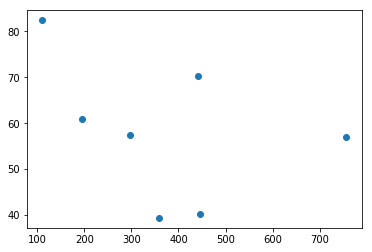

In [51]:
R0 = 1.5
tests = []
infxns = []
for at_mult in at_multipliers_to_try:
    results = at_pareto_results[(R0, at_mult)]
    avg_total_tests = np.mean([r[0] for r in results])
    avg_total_infxns = np.mean([r[-1] for r in results])
    tests.append(avg_total_tests)
    infxns.append(avg_total_infxns)
    print("({},{}): total tests {}, total infxns {}".format(R0, at_mult, avg_total_tests, avg_total_infxns))

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(tests, infxns)

In [52]:
import pickle
pickle.dump(at_pareto_results, open("at_pareto_results.pickle", "wb"))